https://pytorch.org/get-started/locally/  
https://pytorch.org/tutorials/  
https://pytorch.org/docs/stable/index.html  

In [ ]:
# как устанавливать смотреть https://pytorch.org/get-started/locally/
! pip3 install torch torchvision torchaudio

In [2]:
import torch
torch.cuda.is_available()  # проверка видеокарты

True

In [1]:
32*32*3

3072

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
# Download training data from open datasets.
training_data = datasets.MNIST( # FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST( # FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


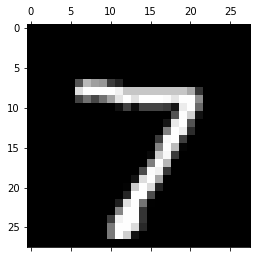

In [8]:
import matplotlib.pyplot as plt

for X, y in test_dataloader:
    plt.matshow(X[0].reshape(28, 28), cmap=plt.cm.gray);    
    break

In [16]:
for X, y in test_dataloader:
    print(X[0])    
    break

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [9]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303465  [   64/60000]
loss: 2.300669  [ 6464/60000]
loss: 2.300498  [12864/60000]
loss: 2.279263  [19264/60000]
loss: 2.288184  [25664/60000]
loss: 2.280909  [32064/60000]
loss: 2.266594  [38464/60000]
loss: 2.266289  [44864/60000]
loss: 2.261763  [51264/60000]
loss: 2.247754  [57664/60000]
Test Error: 
 Accuracy: 30.1%, Avg loss: 2.250949 

Epoch 2
-------------------------------
loss: 2.248996  [   64/60000]
loss: 2.243762  [ 6464/60000]
loss: 2.255557  [12864/60000]
loss: 2.211317  [19264/60000]
loss: 2.233610  [25664/60000]
loss: 2.226019  [32064/60000]
loss: 2.197890  [38464/60000]
loss: 2.216351  [44864/60000]
loss: 2.191741  [51264/60000]
loss: 2.170688  [57664/60000]
Test Error: 
 Accuracy: 50.5%, Avg loss: 2.177955 

Epoch 3
-------------------------------
loss: 2.172389  [   64/60000]
loss: 2.162763  [ 6464/60000]
loss: 2.186688  [12864/60000]
loss: 2.107912  [19264/60000]
loss: 2.147417  [25664/60000]
loss: 2.138868  [32064/600

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

In [3]:
from torch.utils.data import Dataset
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [4]:
class DiabetsDataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.X, self.y = load_diabetes(return_X_y = True)
        self.X = torch.from_numpy(self.X).to(torch.float32)
        self.y = torch.from_numpy(self.y).to(torch.float32)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

In [5]:
diabets = DiabetsDataset()
len(diabets)

442

In [6]:
training_data, test_data = train_test_split(diabets, test_size=0.2)

In [7]:
len(training_data), len(test_data)

(353, 89)

In [8]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 10])
Shape of y: torch.Size([32]) torch.float32


In [63]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): Linear(in_features=10, out_features=10, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): Linear(in_features=10, out_features=10, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (15): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [64]:
loss_fn = nn.MSELoss()  # nn.L1Loss() # nn.CrossEntropyLoss()
loss_mse = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [65]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [66]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    mse_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            mse_loss += loss_mse(pred, y).item()
    test_loss /= num_batches
    mse_loss /= num_batches
    print(f"Test mse loss: {mse_loss:>8f}, avg loss: {test_loss:>8f} \n")

In [67]:
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 37258.035156  [   32/  353]
loss: 30835.640625  [  352/  353]


/home/indianlyc/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 10])

In [41]:
model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
  )
)

linear_relu_stack.0.weight
torch.Size([10, 10])
Parameter containing:
tensor([[ 7.0856e-01,  1.6071e+00, -2.9372e+00, -7.7009e+00, -4.4002e+00,
         -1.2784e+00, -1.6419e+00,  1.6638e+00,  4.4396e+00, -2.5850e+00],
        [ 2.1531e-02,  1.8356e-01,  5.0651e-02,  2.2502e-02,  6.2068e-03,
         -2.7628e-01, -3.1232e-01,  2.4295e-01,  3.9755e-02, -4.0234e-02],
        [-2.8687e-01, -2.8938e-01,  2.4191e-01, -1.5403e-01, -1.2490e-01,
          3.2624e-02, -2.6789e-01, -4.4613e-02,  3.0597e-01,  9.8012e-02],
        [ 3.6890e+00,  9.0710e-01,  6.7388e-01, -1.1567e+00, -4.5652e+00,
         -3.1983e+00,  6.7969e+00,  5.5747e+00, -1.2341e+00, -6.0468e-01],
        [ 5.6011e-01, -6.4943e-01, -3.7323e+00, -6.3790e-01, -6.0316e+00,
          6.4134e+00, -1.5214e+00, -2.6369e+00,  7.6044e+00, -5.5480e-01],
        [ 6.4183e+00,  3.0800e-01, -3.0938e+00,  1.0129e+00, -9.2133e-01,
         -2.5931e+00,  4.0162e+00,  3.8547e+00, -1.9052e+00,  3.8476e-01],
        [-1.4585e+00,  1.2545e+00,  

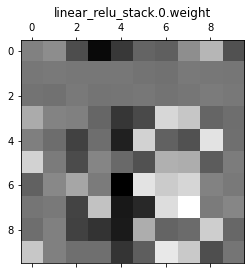

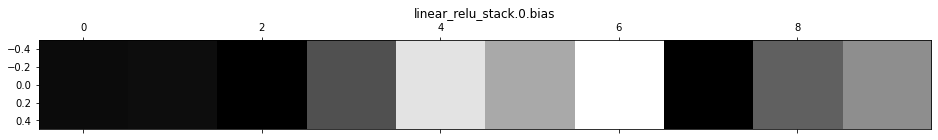

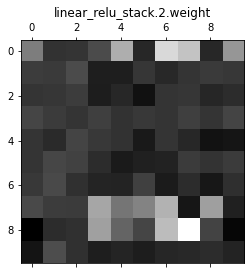

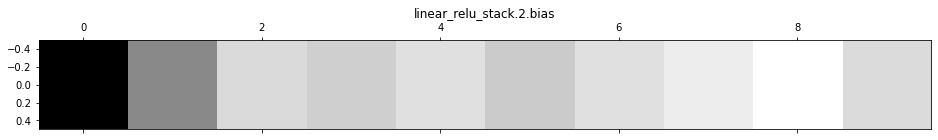

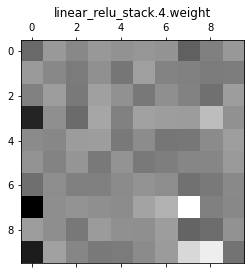

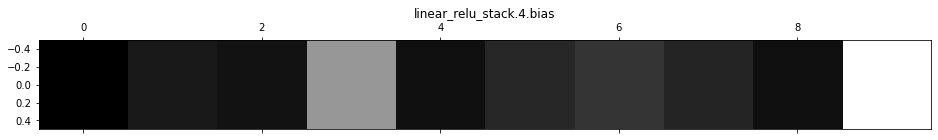

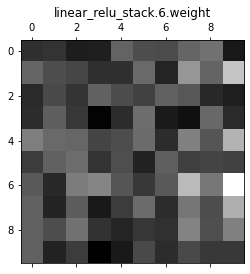

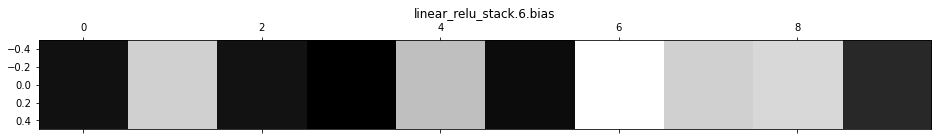

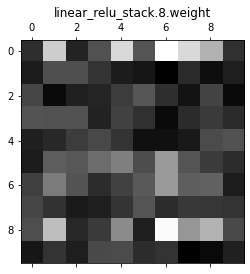

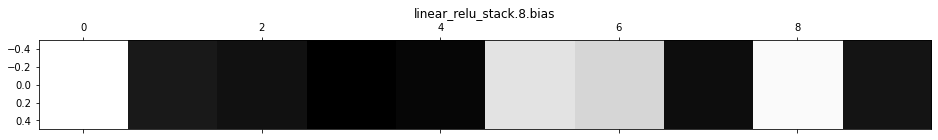

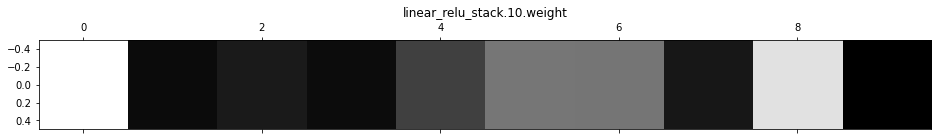

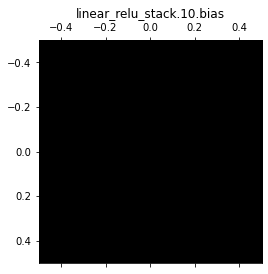

In [52]:
import matplotlib.pyplot as plt


for name, param in model.named_parameters():
    print(name)
    print(param.shape)
    m = param.cpu().detach().numpy()
    if len(m.shape) == 1:
        m = m[None, ...]
        
    plt.matshow(m, cmap=plt.cm.gray)
    plt.title(name)
    print(param)